## 1. Overview

This is a Demo project for the DEGAN framework, which uses Generative Adversarial Networks (GAN) and Density Estimation for probabilistic anomaly detection. 

In this demo project, we trained and configured a Generative Adversarial Network (GAN) model through the DEGAN framework for detecting anomalies on sample time series. The data is divided into three groups (1) training, (2) validation, and (3) testing. Training and validation data are used to configure the Discriminator model (D), which is then used to detect anomalies in the testing data.

The average performance metrics (Precision, Recall, F1) are calculated across all testing time series (TS) -- could be one TS or a collection of TSs. The data could be from one system or from different components of a system. E.g., if the problem is detecting anomalies in building energy use data, the time series could be from one day or multiple days or could be from the air conditioning system or the whole building. The anomaly detection scope is determined by DEGAN users in this demo file.

### Framework

The DEGAN framework, shown in the following diagram, includes three main components: GAN training, D model selection, and probabilistic anomaly detection.

<img src="imgs/degan_framework.png" width="600"/>

### Generator (G) & Discriminator (D)

The implemented architectures of the G and D model employed in this demo of the above framework are shown below. A two-layer Dense neural network was adopted as the base model of G. The input layer is a 1d-tensor of random values drawn from a fixed standard Gaussian distribution ranging between 0 and 1 with a dimension of 128. The two fully connected layers are followed by a Tanh activation layer. For the D model, we employed a 1d-convolutional model, CNN-D, which consists of one convolutional layer (Conv1D) and two fully connected layers. In this implementation, the Conv1D layer has 16 channels of filters with a size of 5. The output of Conv1D is flattened before being fed into the Dense layers.

***(Users of this demo can adjust the architecture and size of the G & D netwroks as they fit their problem of interest in*** `Conv1D_GAN.py` ***)***

<img src="imgs/d_architecture.png" width="700"/>

## 2. Rquired Libraries/Packages

Import the following required libraries and files before running the demo.

Users need to install all required packages following the `requirements.txt`


Users may also directly use the code below (uncomment) to install all required packages.

In [1]:
# pip install -r requirements.txt

In [2]:
import numpy
import random
import tensorflow as tf
from DEGAN.train_val import *
from DEGAN.test import *
from DEGAN.utils import *
from matplotlib import pyplot as plt

## 3. GPU Environment

Users can set up GPU environment based on their need and hardware capabilities.

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Users can uncomment following codes if your system has GPU hardware. 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

Users can use the following session-info to check the current environment.

In [4]:
import session_info
session_info.show()

## 4. Import Dataset

Import the sample dataset. 

In this sample dataset, `training.csv`, `val.csv` and `testing.csv` each have 12 columns where the first column denotes the index number of the time series and the remaining columns denote each of the values that are part of the window size.

***(Users can change this into their customized time series datasets for training, validation, and testing.)***

In [5]:
X_train = pd.read_csv('Data/BE/training.csv')
X_val = pd.read_csv('Data/BE/val.csv')
X_test = pd.read_csv('Data/BE/testing.csv')
ts_df = pd.read_csv('Data/BE/testing time series.csv', nrows=X_test.shape[0])

In [6]:
X_val.shape

(1319, 13)

## 5. Dictionary Settings

For the simplicity of the code and direct adjustments of the hyper parameters in this demo, the following dictionaries are set:

**input_df_dic:**  Dictionary for the input data. Containing the input dataset used for processing. For example, training, validation and testing dataset.

**GAN_param_dic:**  Dictionary for the hyper parameters related to the GAN. Containing the various parameters of the Generative Adversarial Network. For example, learning rate, epochs and threshold.

**post_process_dic:**  Dictionary for the data post processing. Containing the ground truth list, the parameters used for getting the anomaly index list, and the tolerance range used for evaluating the model's performance.

***(Users can customize the parameters in these dictionaries)***

In [7]:
input_df_dic = {
    "train_df": X_train,
    "val_df": X_val,
    "test_df": X_test,
    "ts_df": ts_df,
    "folder_num": 2,
    "num_test": X_test.shape[0]
}

GAN_param_dic={
    "glr": 0.00005,
    "dlr": 0.00002,
    "total_epochs": 500,
    "val_freq": 5,
    "val_criterion": "elbow",
    "ano_thr": 0.01,
    "random_seed": 1234, # Adjust to fit the BE data, originally 2022. 
    "regularization_coeff": 0.0001,
    "latent_dim": 256,
    "out_dim": 12,
    "conv_sz": 3,
    "n_channels": 32,
    "drate": .25,
    "noise_dim": 128
}

post_process_dic={
    # the minimum distance between two KDE peaks
    "peak_dist": 50,
    # the number of bins set over the KDE profile height histogram
    "peak_bins": 21,
    # the number of the quantile of the bins to set the minimum peak height for selection
    "peak_quant": 11,
    # parameter of smoothing level
    "kde_bandwidth": 20,
    # tolerance that shows how effective the algorithm is in detecting anomalies in a given vicinity of the real anomalies.
    "tolerance":[6,12,24,48], 
    # index of the ground truth anomalies in the data set.
    "ground_truth_list": [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423]
    }

## 6. Training & Validation

Training and validating the Generative Adversarial Network on the time series and extracting the discriminator model to be used for testing.

The pseudo code of the training and validation of GAN is shown below:

<img src="imgs/GAN_pseudocode.png" alt="Drawing" style="width: 700px;" align="left"/>

### Inputs & Outputs


**Inputs:**
   
    window_length: int
        Length of the window used in the sliding window method for subsequence extractions.
        
    GAN_param_dic: dict
        Dictionary containing the various parameters of the Generative Adversarial Network.
    
    input_df_dic: dict
        Dictionary containing the input dataset used for processing.
        
**Outputs:**
   
    model: model
        Trained discriminator model used for evaluation of the testing inspection.

In [8]:
# set a random seed for reproduction
random.seed(GAN_param_dic["random_seed"])
numpy.random.seed(GAN_param_dic["random_seed"])
tf.random.set_seed(GAN_param_dic["random_seed"])

# the window length to extract subsequence of original time series data
window_length = 12

input_df_dic["train_df"] = input_df_dic["train_df"].iloc[:,1:(window_length+1)]
input_df_dic["val_df"] = input_df_dic["val_df"].iloc[:,1:(window_length+1)]

model = GAN_train_val(window_length, input_df_dic, GAN_param_dic)

  0%|          | 0/500 [00:00<?, ?it/s]

model saved, best epoch = 215


As shown above, the training and validation process stopped, and the trained model is temporarly stored. 

Next step would be testing the traied model and calculate the performance metrics.

## 7. Testing & Calculate Performance Metrics

Testing the Generative Adversarial Network on the test time series data, and calculating the average performance metrics (Precision, Recall, F1) across the testing data sets.

### Inputs & Outputs


**Inputs:**
   
    model: model
        Trained discriminator model used for evaluation of the testing inspection.
        
**Outputs:**
   
    KDE_scores: dataframe
        Kernel density scores of all the points in the time series.

    anomaly_index_list: list
        Indices where an anomaly has been detected by the trained model.
    
    predictedAnomalies: ndarray
        Predicted anomalies generated after applying kernel density estimation on all the predictions 
        of the model.
        
    metrics: ndarray
        Evaluation (Precision, Recall and F1) scores for the testing time series given the specified 
        tolerance ranges. 
    

In [9]:
KDE_scores, anomaly_index_list, predictedAnomalies, metrics = GAN_test(window_length, 
                                                                       input_df_dic, post_process_dic, model)

[[0.45       0.97       0.61478873 0.89       0.98       0.93283422
  1.         0.99       0.99497487 1.         0.99       0.99497487]]


The above results can be rounded and put into a dataframe for clarity:

In [10]:
def round_metrics(metrics):
    rounded_metrics = np.round(metrics, 2)
    columns = []
    for tolerance in post_process_dic["tolerance"]:
        columns.append("Recall (" + str(tolerance) + ")")
        columns.append("Precision (" + str(tolerance) + ")")
        columns.append("F1 Score (" + str(tolerance) + ")")
    rounded_metrics_df = pd.DataFrame(rounded_metrics, columns = columns, index = ['Score'])
    return rounded_metrics_df

round_metrics(metrics)

,Recall (6),Precision (6),F1 Score (6),Recall (12),Precision (12),F1 Score (12),Recall (24),Precision (24),F1 Score (24),Recall (48),Precision (48),F1 Score (48)
Score,0.45,0.97,0.61,0.89,0.98,0.93,1.0,0.99,0.99,1.0,0.99,0.99


## 8. Output of the Anomaly Detection Task

Apart from the performance metrics, below we can see the actual output results of the anomaly detection task.

Outputs of the anomaly detection tesk can also be visualized in a plot to show the predicted anomalies and the actual anomalies.

### Lists of Actual & Predicted Anomaly locations:

In [11]:
defect_index_list = post_process_dic["ground_truth_list"]
print('Actual anomaly locations:')
print(defect_index_list)

Actual anomaly locations:
[109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423]


In [12]:
print('Predicted anomaly locations:')
print(predictedAnomalies)

Predicted anomaly locations:
[ 126  214 1230 1412]


### Plot of Actual & Predicted Anomalies

The testing time series is denoted in gray while the predicted abnormal windows are shown in green. Kernel density score is applied over these predictions to get the predicted anomalies. These are the locations in the time series with the highest kernel density scores. In the figure, it is shown as a red blob. Actual anomalies are shown as a blue cross.

It can be seen from the plot below that the predicted abnormal windows align witht the actual anomalies.

<Figure size 432x288 with 0 Axes>

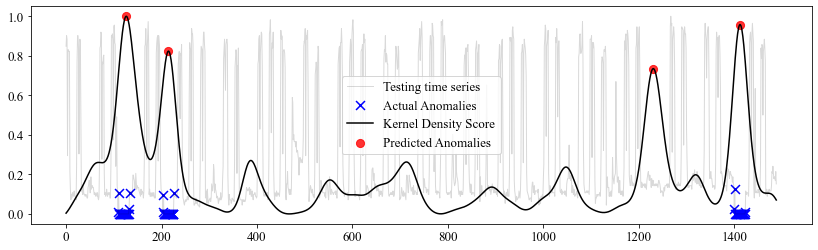

In [13]:
# # Below code has been used to plot the anomaly detection task

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,4))
d = KDE_scores.iloc[predictedAnomalies]

# plot acceleration data
ts = input_df_dic['ts_df']
ts_x = ts['meter_reading']
scaler = MinMaxScaler()
ts_x_scaled = scaler.fit_transform(ts_x.values.reshape(-1,1))
ts_x_scaled = pd.DataFrame(ts_x_scaled)
# ts_x_scaled.index += input_df_dic['ts_df']['Unnamed: 0'][0]
ts_x_scaled.columns = ['Testing time series']  # to show legend
ts_x_scaled.plot(ax=ax, color='black',alpha=0.15,linewidth=1)
f = KDE_scores.iloc[ts_x_scaled.index]


# Plot actual defects
z = defect_index_list
w = ts_x_scaled.loc[defect_index_list]
plt.scatter(z, w, s=80, marker = "x", color='blue',label ="Actual Anomalies") 

# Plot predicted anomalies and KDE profile
f.columns = ['Kernel Density Score']
f.plot(ax=ax, alpha = 1,color='black', label = "Kernel Density Score")      
# x = anomaly_index_list
# y = ts_x_scaled.loc[anomaly_index_list]
# plt.scatter(x, y, s=10, alpha=0.8,color='green',label ="Predicted Abnormal Windows")
x = predictedAnomalies
y = ts_x_scaled.loc[predictedAnomalies]
plt.scatter(x, d, s=66, alpha=0.8,color='red',label ="Predicted Anomalies")


plt.legend(prop={'family': 'Times New Roman','size':13})
plt.xticks(fontproperties='Times New Roman',fontsize=13)
plt.yticks(fontproperties='Times New Roman',fontsize=13)
plt.show()
